In [38]:
from mpc import *
from sympy import *

In [39]:
# Total simulation time 24h (1440m)
total_time = 1440  

# Sample time 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


## Model linearization

In [40]:
k_m0_L = 3.20e-2  
k_m0_T = 1.19e-1  
k_m_L = 8.30
k_m_T = 2.06
k_p_L = 9.726e-1  
k_p_T = 9.726e-1  
g_m_L = 1.386e-1
g_m_T = 1.386e-1
g_p_L = 1.65e-2
g_p_T = 1.65e-2
theta_LacI = 31.94
theta_TetR = 30.00
theta_IPTG = 9.06e-2
theta_aTc = 11.65
eta_LacI = 2.00
eta_TetR = 2.00
eta_IPTG = 2.00
eta_aTc = 2.00

x1 = Symbol('x1')
x2 = Symbol('x2')
x3 = Symbol('x3')
x4 = Symbol('x4')
v1 = Symbol('v1')
v2 = Symbol('v2')

dx1 = k_m0_L + k_m_L*(1 / (1 + ((x4/theta_TetR) * (1 / (1 + (v1/theta_aTc)**eta_aTc)))**eta_TetR)) - g_m_L * x1
dx2 = k_m0_T + k_m_T*(1 / (1 + ((x3/theta_LacI) * (1 / (1 + (v2/theta_IPTG)**eta_IPTG)))**eta_LacI)) - g_m_T * x2
dx3 = k_p_L * x1 - g_p_L * x3
dx4 =  k_p_T * x2 - g_p_T * x4

In [41]:
A = [
        [dx1.diff(x1), dx1.diff(x2), dx1.diff(x3), dx1.diff(x4)],
        [dx2.diff(x1), dx2.diff(x2), dx2.diff(x3), dx2.diff(x4)],
        [dx3.diff(x1), dx3.diff(x2), dx3.diff(x3), dx3.diff(x4)],
        [dx4.diff(x1), dx4.diff(x2), dx4.diff(x3), dx4.diff(x4)]
    ]

B = [
        [dx1.diff(v1), dx1.diff(v2)],
        [dx2.diff(v1), dx2.diff(v2)],
        [dx3.diff(v1), dx3.diff(v2)],
        [dx4.diff(v1), dx4.diff(v2)]
    ]

C = [
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]

D = [
        [0, 0],
        [0, 0]
    ]

In [42]:
equilibria = np.array([13.0, 5.0, 750.0, 300.0, 23.0, 0.34])

In [43]:
f = lambdify([(x1, x2, x3, x4, v1, v2)], A)
A = np.array(f(equilibria))

f = lambdify([(x1, x2, x3, x4, v1, v2)], B)
B = np.array(f(equilibria))

## Design and application of an MPC strategy to the linear model

In [44]:
def template_model(A, B, LacI_ref=750, TetR_ref=300):

    model = do_mpc.model.Model(model_type='continuous')

    _x = model.set_variable(var_type='states', var_name='x', shape=(4,1))
    _u = model.set_variable(var_type='inputs', var_name='u', shape=(2,1))

    x_next = A@_x+B@_u
    
    model.set_rhs('x', x_next)
    model.set_expression(expr_name='cost', expr=(model.x['x', 2] - LacI_ref)**2 + (model.x['x', 3] - TetR_ref)**2)

    model.setup()

    return model

In [45]:
def template_mpc(model, setup_mpc):
    
    mpc = do_mpc.controller.MPC(model)    

    mpc.set_param(**setup_mpc)

    # Cost function
    mterm = model.aux['cost']
    lterm = model.aux['cost']

    mpc.set_objective(mterm=mterm, lterm=lterm)
    #mpc.set_rterm(u[0]=1, u[1]=1)

    # Constraints
    mpc.bounds['lower', '_x', 'x'] = np.array([[3.20e-2], [1.19e-1], [0], [0]])

    mpc.bounds['lower', '_u', 'u'] = np.array([[0], [0]])
    mpc.bounds['upper', '_u', 'u'] = np.array([[35], [0.35]])

    mpc.setup()

    return mpc


In [46]:
def template_simulator(model, t_step):
    
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step=t_step)

    simulator.setup()

    return simulator


In [47]:
%%capture

setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': False,
}

model = template_model(A, B)
mpc = template_mpc(model, setup_mpc)
simulator = template_simulator(model, t_step)
estimator = do_mpc.estimator.StateFeedback(model)

simulator.reset_history()

x_0 = np.array([30, 50, 400, 125])

mpc.x0 = x_0
simulator.x0 = x_0
estimator.x0 = x_0

mpc.set_initial_guess()

for k in range(steps):

    u = mpc.make_step(x_0)

    if (mpc.t0 - t_step) % 15 == 0:
        ukm1 = u
    else:
        u = ukm1

    y_next = simulator.make_step(u)
    x_0 = estimator.make_step(y_next)

In [48]:
states = {
    'mRNA_LacI': [x[0] for x in mpc.data['_x', 'x']],
    'mRNA_TetR': [x[1] for x in mpc.data['_x', 'x']],
    'LacI': [x[2] for x in mpc.data['_x', 'x']],
    'TetR': [x[3] for x in mpc.data['_x', 'x']]
}

u1 = [x[0] for x in mpc.data['_u', 'u']]
u2 = [x[1] for x in mpc.data['_u', 'u']]

for i in range(len(u1)):
    if i % 15 != 0:
        u1[i] = u1[i-1]
        u2[i] = u2[i-1]

inputs = {
    'aTc': u1,
    'IPTG': u2
}

# Get average trajectory every 240 minutes (14400 s)
# Get samples every 5 minutes (300 s)
# Samples in 240 minutes = 240/5 = 48 samples
avg_samples_range = int(avg_period/t_step)

avg_LacI = [np.mean(states['LacI'][x:x + avg_samples_range]) for x in range(0, len(states['LacI']), avg_samples_range)]
avg_TetR = [np.mean(states['TetR'][x:x + avg_samples_range]) for x in range(0, len(states['TetR']), avg_samples_range)]

avg_trajectory = {
    'LacI': avg_LacI,
    'TetR': avg_TetR
}

cost = [x[0] for x in mpc.data['_aux', 'cost'].tolist()]
time = [x[0] for x in mpc.data['_time'].tolist()]

data = {
    'states': states,
    'inputs': inputs,
    'avg_traj' : avg_trajectory,
    'cost': cost,
    'time': time,
    'ISE': 0,
    'ITAE': 0
}

In [49]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
ISE, ITAE = compute_performance_metrics(data, total_time, t_step, avg_period, LacI_ref, TetR_ref)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 4.38e+01
ITAE: 1.89e+05


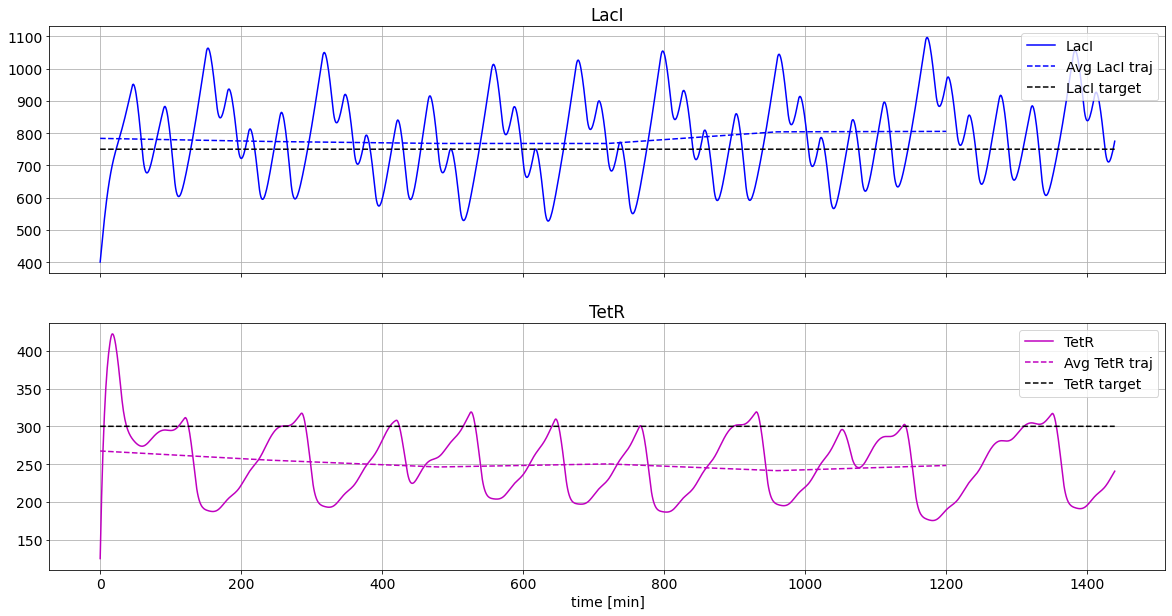

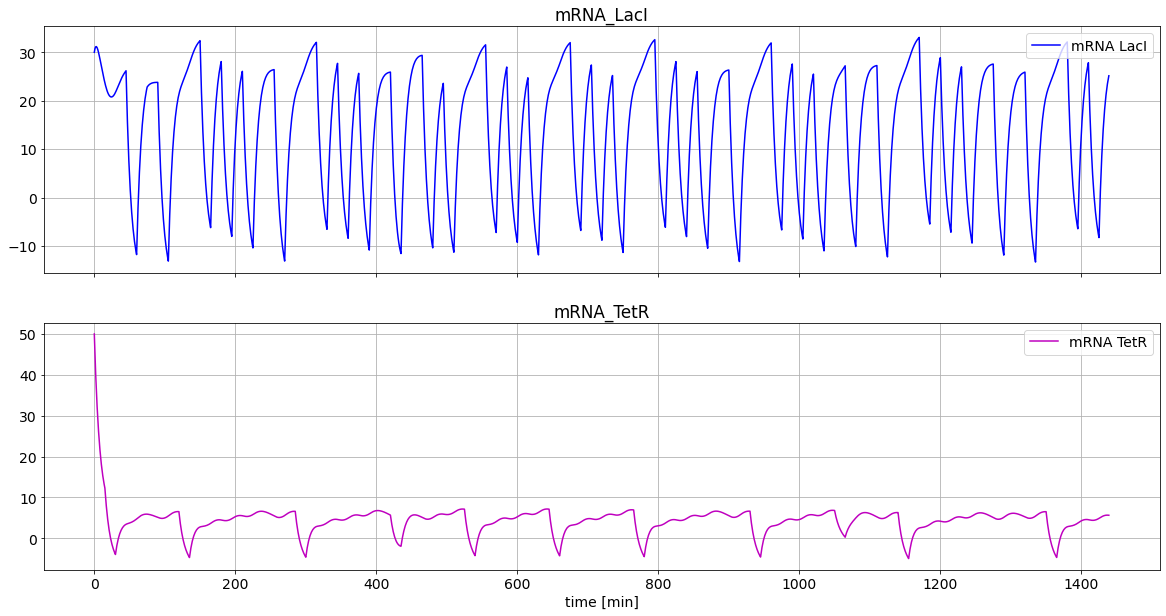

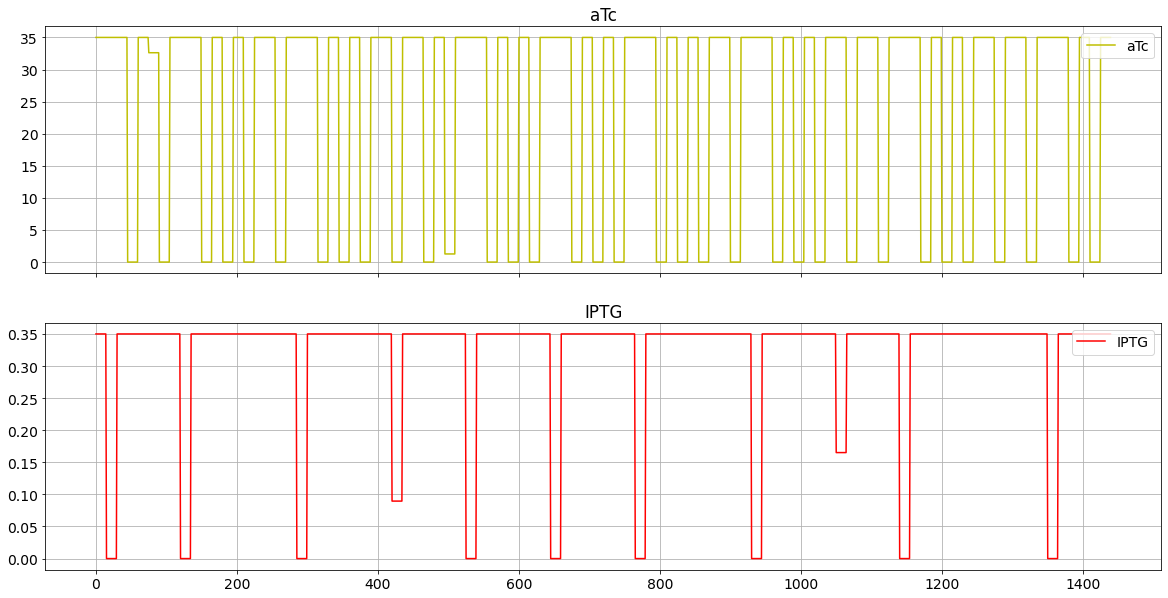

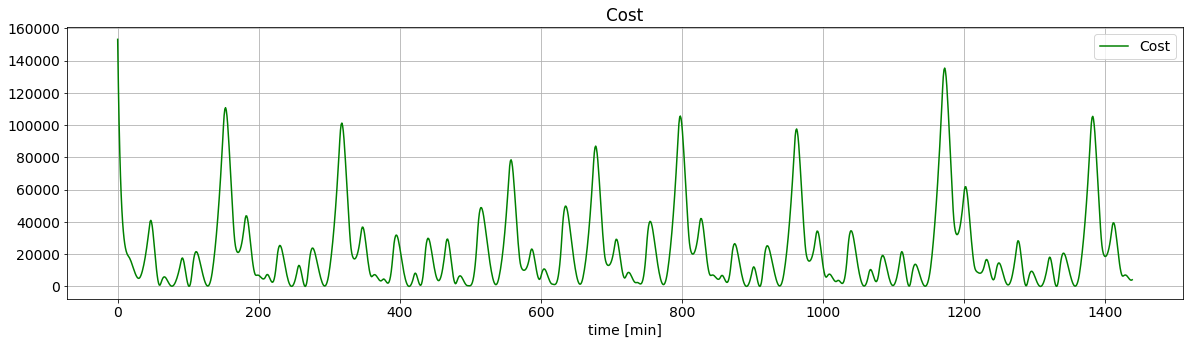

In [50]:
fig_x = 20
fig_y = 10

avg_x = np.arange(0, total_time, avg_period)

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14


# -------------------- Proteins -------------------- #
# --- LacI --- #
figure_proteins, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

axes[0].set_ylabel('')
axes[0].set_title('LacI')

line_LacI, = axes[0].plot(data['time'], data['states']['LacI'], color='b')
line_avg_LacI, = axes[0].plot(avg_x, data['avg_traj']['LacI'], color='b', linestyle='--')
line_ref_LacI, = axes[0].plot(data['time'], LacI_ref*np.ones(len(data['time'])), color='k', linestyle='--')
axes[0].legend(['LacI', 'Avg LacI traj', 'LacI target'], loc='upper right')

# --- TetR --- #
axes[1].set_ylabel('')
axes[1].set_title('TetR')
line_TetR, = axes[1].plot(data['time'], data['states']['TetR'], color='m')
line_avg_TetR, = axes[1].plot(avg_x, data['avg_traj']['TetR'], color='m', linestyle='--')
line_ref_TetR, = axes[1].plot(data['time'], TetR_ref*np.ones(len(data['time'])), color='k', linestyle='--')
axes[1].legend(['TetR', 'Avg TetR traj', 'TetR target'], loc='upper right')
axes[1].set_xlabel('time [min]')

figure_proteins.set_facecolor("white")

# -------------------- mRNAs -------------------- #
# --- mRNA LacI --- #
figure_mRNAs, axes1 = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
axes1[0].set_ylabel('')
axes1[0].set_title('mRNA_LacI')
line_mRNA_LacI, = axes1[0].plot(data['time'], data['states']['mRNA_LacI'], color='b')
axes1[0].legend(['mRNA LacI'], loc='upper right')

# --- mRNA TetR --- #
axes1[1].set_ylabel('')
axes1[1].set_title('mRNA_TetR')
line_mRNA_TetR, = axes1[1].plot(data['time'], data['states']['mRNA_TetR'], color='m')
axes1[1].legend(['mRNA TetR'], loc='upper right')
axes1[1].set_xlabel('time [min]')

figure_mRNAs.set_facecolor("white")

# -------------------- External inductors concentrations -------------------- #
# --- aTc --- #
figure_inductors, axes2 = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
axes2[0].set_ylabel('')
axes2[0].set_title('aTc')
line_aTc, = axes2[0].plot(data['time'], data['inputs']['aTc'], color='y')
axes2[0].legend(['aTc'], loc='upper right')

# --- IPTG --- #
axes2[1].set_ylabel('')
axes2[1].set_title('IPTG')
line_IPTG, = axes2[1].plot(data['time'], data['inputs']['IPTG'], color='r')
axes2[1].legend(['IPTG'], loc='upper right')

figure_inductors.set_facecolor("white")
# -------------------- Cost -------------------- #
figure_cost, axes4 = plt.subplots(1, figsize=(fig_x, fig_y/2))
axes4.set_ylabel('')
axes4.set_title('Cost')
line_cost, = axes4.plot(data['time'], data['cost'], color='g')
axes4.legend(['Cost'], loc='upper right')
axes4.set_xlabel('time [min]')

figure_cost.set_facecolor("white")

figures = np.array([figure_proteins, figure_mRNAs, figure_inductors, figure_cost])
lines = np.array([line_LacI, line_avg_LacI, line_ref_LacI, line_TetR, line_avg_TetR, line_ref_TetR,
                  line_mRNA_LacI, line_mRNA_TetR, line_aTc, line_IPTG, line_cost])


In [51]:
export_results(data, 'linear', 'results', 'w')

In [52]:
animate_results('linear', 'proteins', update_protein, figures[0], (data, lines[0:6], np.arange(0, total_time, avg_period)), steps)
animate_results('linear', 'mRNAs', update_mRNA, figures[1], (data, lines[6:8]), steps)
animate_results('linear', 'external_inducers', update_external_inducers, figures[2], (data, lines[8:10]), steps)
animate_results('linear', 'cost', update_cost, figures[3], (data, lines[10:11]), steps)